##Assignment: PySpark and Machine Learning
###Ashutosh Anand
###202318035

In [ ]:
#!pip install pyspark

In [ ]:
#pip install ucimlrepo

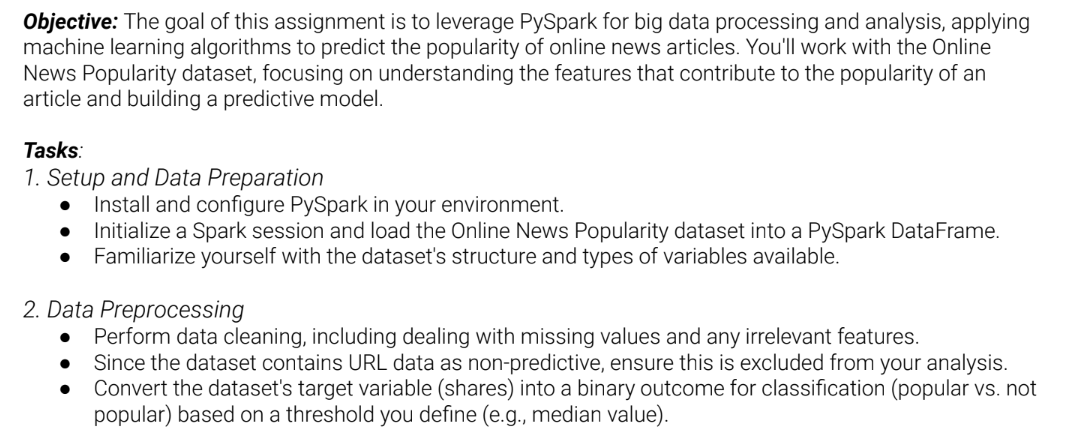

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from ucimlrepo import fetch_ucirepo
import pandas as pd
from pyspark.sql.functions import col, count, mean, stddev, corr, avg, when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import avg
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [9]:
# fetching dataset
news_popularity = fetch_ucirepo(id=332)

X = news_popularity.data.features
y = news_popularity.data.targets

In [10]:
# Initialize Spark session
spark = SparkSession.builder.appName("NewsPopularity").getOrCreate()

# Merging X and y into a single DataFrame
df_combined = pd.concat([X, y], axis=1)

# Convert the merged DataFrame to PySpark DataFrame without explicitly defining a schema
df_spark = spark.createDataFrame(df_combined)
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [11]:
# Print the dataset schema to understand its structure
print("\nSummary statistics:")
df_spark.describe().show()
print("\nSchema:")
df_spark.printSchema()

# Task 2: Data Preprocessing
# Remove irrelevant features, including the URL column (already excluded in the schema)
# Convert the 'shares' column to a binary outcome (popular vs. not popular)
median_shares = df_spark.approxQuantile(" shares", [0.5], 0.0)[0]
data = df_spark.withColumn("label", when(col(" shares") >= median_shares, 1).otherwise(0))

# Select features for the model and assemble them into a feature vector
feature_columns = [col for col in data.columns if col not in ['shares', 'label']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Task 3: Model Training and Evaluation
# Create a RandomForestClassifier model
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Define a Pipeline that includes feature assembly and the classifier
pipeline = Pipeline(stages=[assembler, rf_classifier])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.2f}")


Summary statistics:
+-------+------------------+-----------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------------+------------------

In [12]:
# Drop rows with any null values
df_cleaned = df_spark.na.drop()

# Show the first few rows of the cleaned DataFrame
df_cleaned.show(5)

# Display summary statistics for the cleaned features
print("\nSummary statistics for cleaned features:")
df_cleaned.describe().show()

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [13]:
median_shares = df_spark.approxQuantile(" shares", [0.5], 0.01)[0]
df_spark = df_cleaned.withColumn("shares_binary", when(col(" shares") >= median_shares, 1).otherwise(0))

# Show the first few rows of the preprocessed DataFrame
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

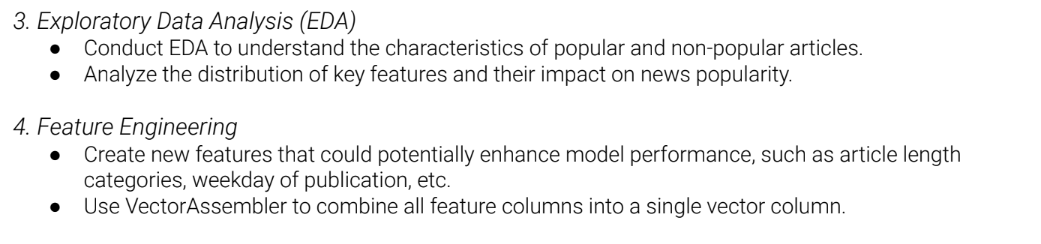

In [14]:
# Summary statistics for popular and non-popular articles
df_grouped = df_spark.groupby("shares_binary").agg(
    count("*").alias("count"),
    mean(" n_tokens_title").alias("avg_title_length"),
    mean(" n_tokens_content").alias("avg_content_length"),
    mean(" num_hrefs").alias("avg_num_hrefs"),
    mean(" num_imgs").alias("avg_num_imgs"),
    mean(" num_videos").alias("avg_num_videos"),
    mean(" shares").alias("avg_shares"),
    mean(" global_subjectivity").alias("avg_global_subjectivity"),
    mean(" global_sentiment_polarity").alias("avg_global_sentiment_polarity"),
    mean(" rate_positive_words").alias("avg_rate_positive_words"),
    mean(" rate_negative_words").alias("avg_rate_negative_words")
)

df_grouped.show()

# Distribution of key features for popular and non-popular articles
features = [
    " n_tokens_title", " n_tokens_content", " num_hrefs", " num_imgs",
    " num_videos", " global_subjectivity", " global_sentiment_polarity",
    " rate_positive_words", " rate_negative_words"
]

for feature in features:
    df_spark.groupby("shares_binary").agg(
        mean(col(feature)).alias(f"avg_{feature}"),
        stddev(col(feature)).alias(f"stddev_{feature}")
    ).show()

# Correlation analysis between features and the target variable
for feature in features:
    correlation = df_spark.stat.corr(feature, "shares_binary")
    print(f"Correlation between {feature} and shares_binary: {correlation:.2f}")

+-------------+-----+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------+-----------------------------+-----------------------+-----------------------+
|shares_binary|count|  avg_title_length|avg_content_length|     avg_num_hrefs|      avg_num_imgs|    avg_num_videos|       avg_shares|avg_global_subjectivity|avg_global_sentiment_polarity|avg_rate_positive_words|avg_rate_negative_words|
+-------------+-----+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------+-----------------------------+-----------------------+-----------------------+
|            1|21154|10.311761369008225| 564.7633544483313|11.839604802874161| 5.066134064479531|1.2781034319750402|5568.213860262835|     0.4507946492337189|           0.1259741737156871|     0.6897556240000232|    0.27753188663626893|
|            0|18490|10.498269334775554|  525.636884

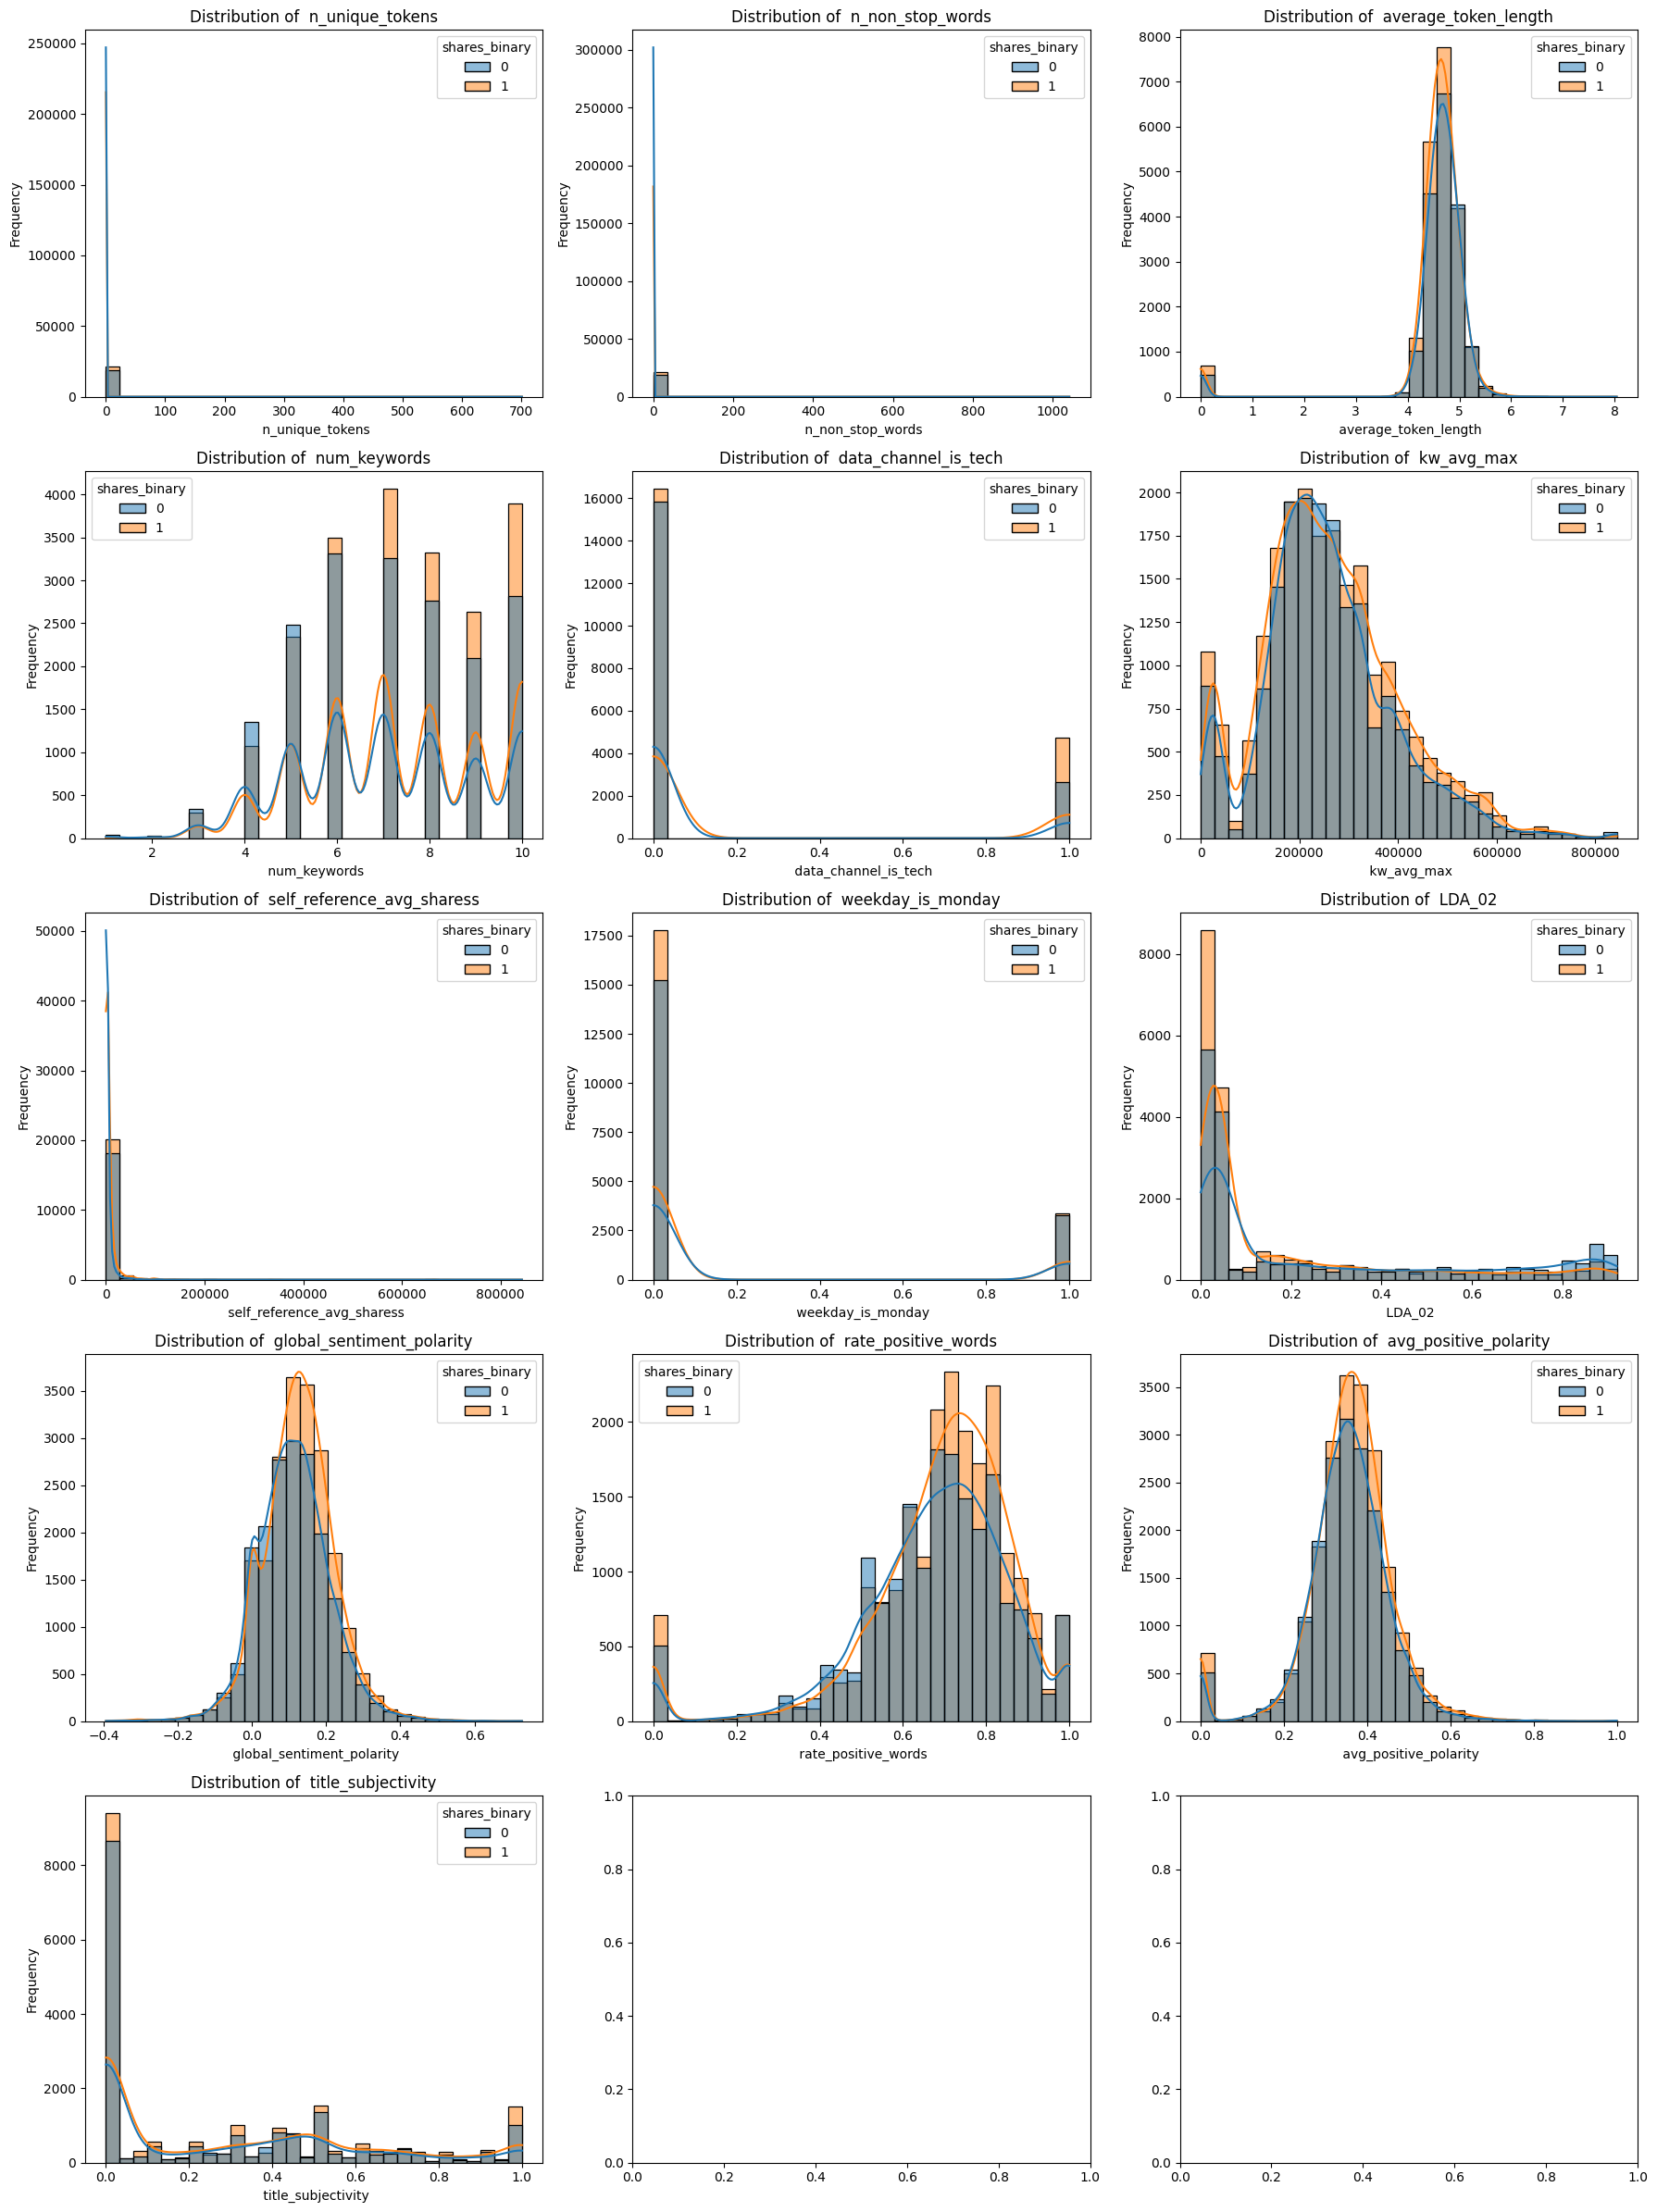

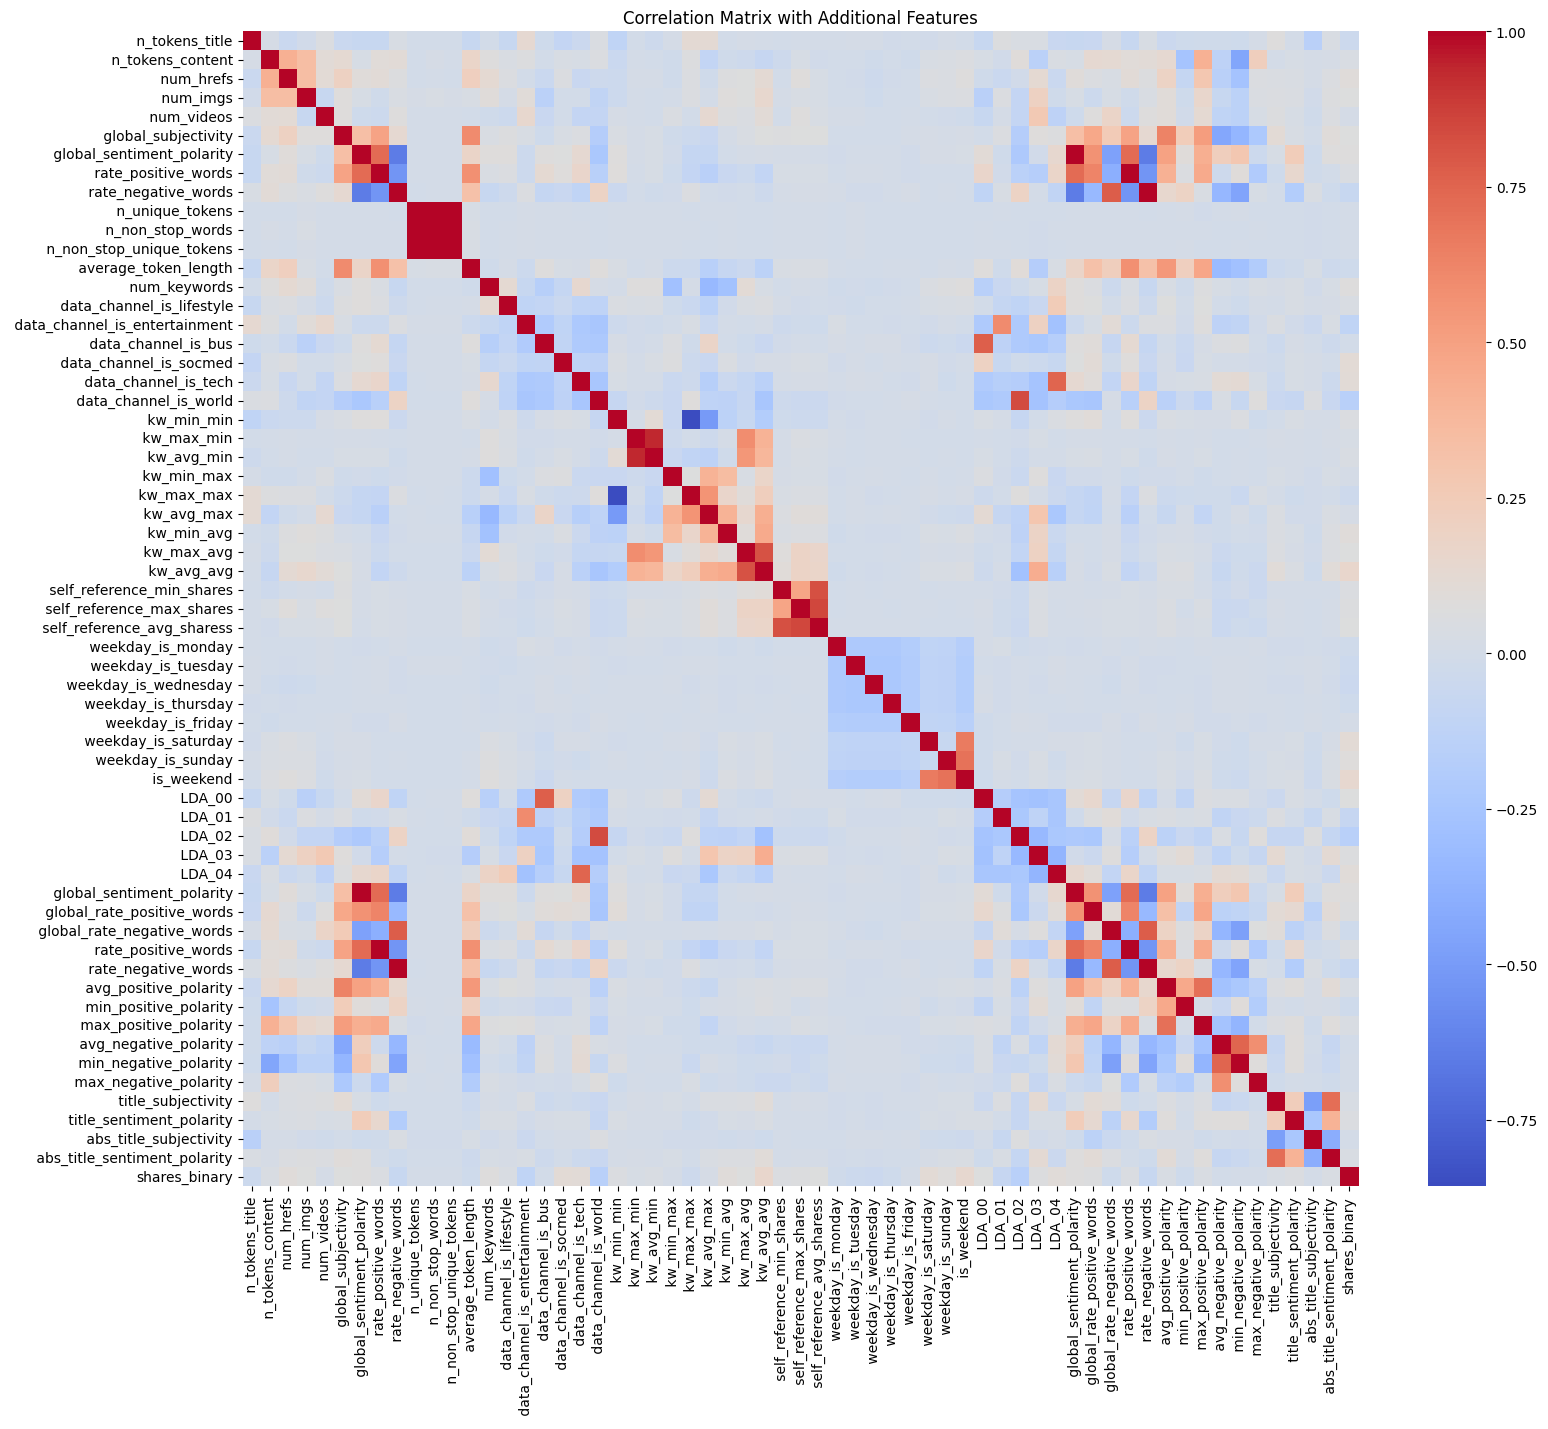

In [16]:
# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_spark.toPandas()

# List of additional features for EDA
additional_features = [
    " n_unique_tokens", " n_non_stop_words", " n_non_stop_unique_tokens",
    " average_token_length", " num_keywords", " data_channel_is_lifestyle",
    " data_channel_is_entertainment", " data_channel_is_bus",
    " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world",
    " kw_min_min", " kw_max_min", " kw_avg_min", " kw_min_max",
    " kw_max_max", " kw_avg_max", " kw_min_avg", " kw_max_avg", " kw_avg_avg",
    " self_reference_min_shares", " self_reference_max_shares",
    " self_reference_avg_sharess", " weekday_is_monday", " weekday_is_tuesday",
    " weekday_is_wednesday", " weekday_is_thursday", " weekday_is_friday",
    " weekday_is_saturday", " weekday_is_sunday", " is_weekend",
    " LDA_00", " LDA_01", " LDA_02", " LDA_03", " LDA_04",
    " global_sentiment_polarity", " global_rate_positive_words",
    " global_rate_negative_words", " rate_positive_words", " rate_negative_words",
    " avg_positive_polarity", " min_positive_polarity", " max_positive_polarity",
    " avg_negative_polarity", " min_negative_polarity", " max_negative_polarity",
    " title_subjectivity", " title_sentiment_polarity",
    " abs_title_subjectivity", " abs_title_sentiment_polarity"
]

# Plotting histograms for selected features
selected_features = [
    " n_unique_tokens", " n_non_stop_words", " average_token_length",
    " num_keywords", " data_channel_is_tech", " kw_avg_max",
    " self_reference_avg_sharess", " weekday_is_monday", " LDA_02",
    " global_sentiment_polarity", " rate_positive_words", " avg_positive_polarity",
    " title_subjectivity"
]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.histplot(data=df_pandas, x=feature, hue="shares_binary", bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Correlation analysis with additional features
corr_features = features + additional_features + ["shares_binary"]
corr_matrix = df_pandas[corr_features].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", annot=False)
plt.title("Correlation Matrix with Additional Features")
plt.show()

In [17]:
# Calculate the average of n_tokens_title for popular and non-popular articles
avg_n_tokens_title_popular = df_spark.filter(col("shares_binary") == 1).agg(avg(" n_tokens_title")).collect()[0][0]
avg_n_tokens_title_non_popular = df_spark.filter(col("shares_binary") == 0).agg(avg(" n_tokens_title")).collect()[0][0]

print("Average n_tokens_title for Popular Articles:", avg_n_tokens_title_popular)
print("Average n_tokens_title for Non-Popular Articles:", avg_n_tokens_title_non_popular)

Average n_tokens_title for Popular Articles: 10.311761369008225
Average n_tokens_title for Non-Popular Articles: 10.498269334775554


In [18]:
# Create a new feature for article length categories
df_spark = df_spark.withColumn(" article_length_category",
                               when(col(" n_tokens_content") < 500, "Short")
                               .when((col(" n_tokens_content") >= 500) & (col(" n_tokens_content") < 1000), "Medium")
                               .otherwise("Long"))

# Create a new feature for the weekday of publication
weekday_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday",
                    " weekday_is_thursday", " weekday_is_friday", " weekday_is_saturday", " weekday_is_sunday"]

df_spark = df_spark.withColumn("publication_weekday",
                               when(col(" weekday_is_monday") == 1, "Monday")
                               .when(col(" weekday_is_tuesday") == 1, "Tuesday")
                               .when(col(" weekday_is_wednesday") == 1, "Wednesday")
                               .when(col(" weekday_is_thursday") == 1, "Thursday")
                               .when(col(" weekday_is_friday") == 1, "Friday")
                               .when(col(" weekday_is_saturday") == 1, "Saturday")
                               .when(col(" weekday_is_sunday") == 1, "Sunday")
                               .otherwise("Unknown"))

# Show the first few rows of the DataFrame with new features
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [24]:
before_features=X
before_features.columns
drop_columns = [' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' n_tokens_content']
# Convert drop_columns list to a set
drop_columns_set = set(drop_columns)
# Drop the specified columns
before_features = before_features.drop(columns=drop_columns_set)

In [46]:
df_spark = df_spark.drop('article_length_category_ind_4','article_length_category_encoded_5','complete_features_','complete_features_norm_')

In [47]:
# Feature Engineering
# Creating new features for article length categories and also for is_weekend and is_weekday
df_spark = df_spark.withColumn("article_length_category",
                               F.when(col(" n_tokens_content") < 500, "short")
                               .when((col(" n_tokens_content") >= 500) & (col(" n_tokens_content") < 1000), "medium")
                               .otherwise("long"))
df_spark = df_spark.withColumn(" is_weekend", when((col(" weekday_is_saturday") == 1) | (col(" weekday_is_sunday") == 1), 1).otherwise(0))
df_spark = df_spark.withColumn(" is_weekday", when((col(" weekday_is_monday") == 1) | (col(" weekday_is_tuesday") == 1) |
                                                  (col(" weekday_is_wednesday") == 1) | (col(" weekday_is_thursday") == 1) |
                                                  (col(" weekday_is_friday") == 1), 1).otherwise(0))

# Number of Images and Videos
df_spark = df_spark.withColumn("num_images_videos", col(" num_imgs") + col(" num_videos"))

indexer = StringIndexer(inputCol="article_length_category", outputCol="article_length_category_ind_4")
df_spark = indexer.fit(df_spark).transform(df_spark)

# One-hot encoding for article_length_category_index
encoder = OneHotEncoder(inputCols=["article_length_category_ind_4"], outputCols=["article_length_category_encoded_5"])
encoder_model = encoder.fit(df_spark)
df_spark = encoder_model.transform(df_spark)

# List of new column names
new_column_names = [' is_weekend', ' is_weekday', 'article_length_category_encoded_5','num_images_videos']

# Concatenating the existing column names with the new column names
new_feature_columns = before_features.columns.tolist() + new_column_names

assembler = VectorAssembler(inputCols=new_feature_columns, outputCol="complete_features_")
df_spark = assembler.transform(df_spark)

scaler = StandardScaler(inputCol="complete_features_", outputCol="complete_features_norm_")
df_spark = scaler.fit(df_spark).transform(df_spark)
# Showing the first few rows with the new feature and the vector column
df_spark.select(" n_tokens_title", " title_sentiment_polarity"," is_weekend", " is_weekday", "article_length_category","num_images_videos","complete_features_", "complete_features_norm_", 'shares_binary').show(5, truncate=False)

+---------------+-------------------------+-----------+-----------+-----------------------+-----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

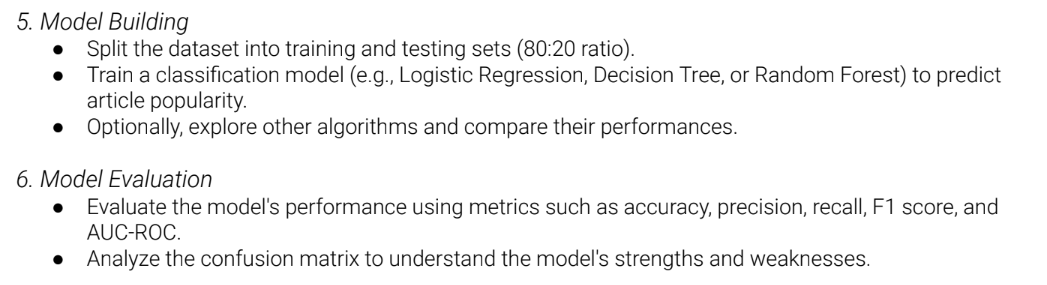

In [56]:


# Split the dataset into training and testing sets (80:20 ratio)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="complete_features_norm_", labelCol="shares_binary")
rf_model = rf_classifier.fit(train_data)

# Predictions on the test set
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(labelCol="shares_binary")
print(f"Area Under ROC (Random Forest): {binary_evaluator.evaluate(rf_predictions, {binary_evaluator.metricName: 'areaUnderROC'}):.4f}")

multi_evaluator = MulticlassClassificationEvaluator(labelCol="shares_binary", metricName="accuracy")
print(f"Accuracy (Random Forest): {multi_evaluator.evaluate(rf_predictions):.4f}")

# Optional: Train a Logistic Regression model
lr_classifier = LogisticRegression(featuresCol="complete_features_norm_", labelCol="shares_binary")
lr_model = lr_classifier.fit(train_data)
lr_predictions = lr_model.transform(test_data)
print(f"Area Under ROC (Logistic Regression): {binary_evaluator.evaluate(lr_predictions, {binary_evaluator.metricName: 'areaUnderROC'}):.4f}")
print(f"Accuracy (Logistic Regression): {multi_evaluator.evaluate(lr_predictions):.4f}")

# Optional: Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(featuresCol="complete_features_norm_", labelCol="shares_binary")
dt_model = dt_classifier.fit(train_data)
dt_predictions = dt_model.transform(test_data)
print(f"Area Under ROC (Decision Tree): {binary_evaluator.evaluate(dt_predictions, {binary_evaluator.metricName: 'areaUnderROC'}):.4f}")
print(f"Accuracy (Decision Tree): {multi_evaluator.evaluate(dt_predictions):.4f}")

Area Under ROC (Random Forest): 0.6970
Accuracy (Random Forest): 0.6429
Area Under ROC (Logistic Regression): 0.7004
Accuracy (Logistic Regression): 0.6465
Area Under ROC (Decision Tree): 0.5176
Accuracy (Decision Tree): 0.6372


In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluate_model(predictions, label_col):
    """
    Evaluates the performance of a model on test data and prints accuracy, precision, recall, F1 score,
    and AUC-ROC.

    Parameters:
    - predictions: DataFrame containing the 'label' and 'prediction' columns.
    - label_col: The name of the label column.
    """
    # Define evaluators for binary classification
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col)
    precision_evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol=label_col)
    recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol=label_col)
    f1_evaluator = MulticlassClassificationEvaluator(metricName="f1", labelCol=label_col)

    # Calculate metrics
    accuracy = predictions.filter(predictions["prediction"] == predictions[label_col]).count() / predictions.count()
    auc_roc = binary_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    # Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("AUC-ROC:", auc_roc)

# Evaluate Logistic Regression model
print("Evaluating Logistic Regression Classifier:")
evaluate_model(lr_predictions, "shares_binary")

# Evaluate Random Forest model
print("\nEvaluating Random Forest Classifier:")
evaluate_model(rf_predictions, "shares_binary")

# Evaluate Decision Tree model
print("\nEvaluating Decision Tree Classifier:")
evaluate_model(dt_predictions, "shares_binary")

Evaluating Logistic Regression Classifier:
Accuracy: 0.64648537711647
Precision: 0.645756972530944
Recall: 0.64648537711647
F1 Score: 0.6459728602864863
AUC-ROC: 0.7003776341045181

Evaluating Random Forest Classifier:
Accuracy: 0.6428937916880452
Precision: 0.6425447152528757
Recall: 0.6428937916880452
F1 Score: 0.6369149746353755
AUC-ROC: 0.6970347701697011

Evaluating Decision Tree Classifier:
Accuracy: 0.6372498717290919
Precision: 0.6389451293306616
Recall: 0.6372498717290919
F1 Score: 0.6377354104077216
AUC-ROC: 0.5175661060044777


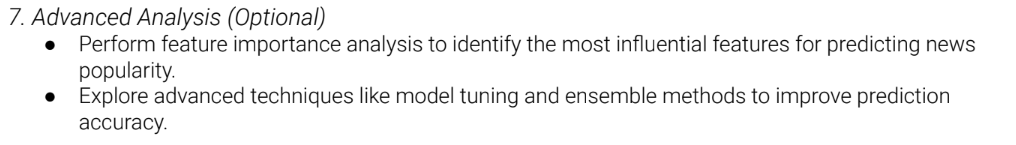

In [62]:
# Extract feature importances from the Random Forest model
rf_feature_importances = rf_model.featureImportances

# Create a list of feature names
feature_names = feature_columns + ['article_length_category_vec', 'weekday_of_publication_vec']

# Zip feature names with their importances and sort them
rf_importances = sorted(zip(feature_names, rf_feature_importances), key=lambda x: x[1], reverse=True)

# Print the top 10 most important features
print("Top 10 Feature Importances (Random Forest):")
for feature, importance in rf_importances[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Feature Importances (Random Forest):
 kw_min_avg: 0.1501
 weekday_is_tuesday: 0.1191
 kw_max_avg: 0.1158
 kw_avg_avg: 0.0716
 self_reference_max_shares: 0.0655
 data_channel_is_socmed: 0.0562
 min_positive_polarity: 0.0558
 data_channel_is_lifestyle: 0.0518
 data_channel_is_tech: 0.0514
 max_positive_polarity: 0.0349


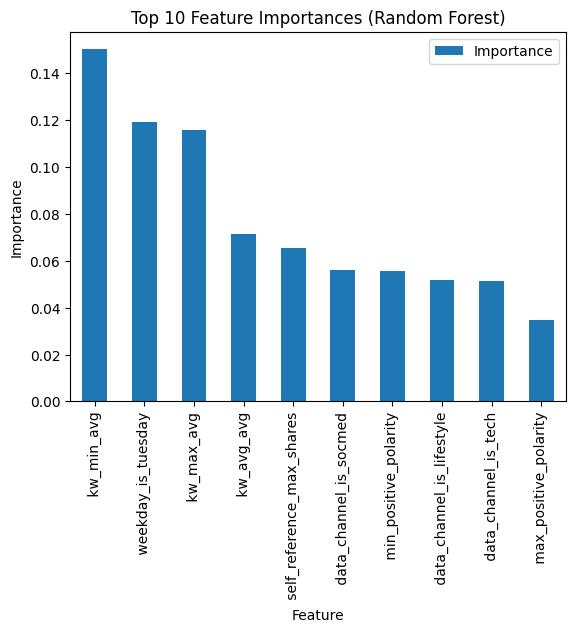

In [67]:
# Convert feature importances to a Pandas DataFrame
importances_df = pd.DataFrame(rf_importances, columns=['Feature', 'Importance'])

# Plot the top 10 most important features
importances_df.sort_values(by='Importance', ascending=False).head(10).plot(kind='bar', x='Feature', y='Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.show()

kw_min_avg: This feature, which represents the average of the minimum keyword relevance scores, is the most important feature. It suggests that the relevance of the least relevant keywords in an article plays a significant role in its popularity.

weekday_is_tuesday: The day of the week when the article is published seems to be important, with articles published on Tuesday being particularly influential in this model.

kw_max_avg: The average of the maximum keyword relevance scores is also important, indicating that the relevance of the most relevant keywords is a key factor in article popularity.

kw_avg_avg: The average of the average keyword relevance scores is another important feature, suggesting that overall keyword relevance is important.

self_reference_max_shares: The maximum number of shares of articles that reference the current article is important, indicating that self-referential popularity is a factor.

data_channel_is_socmed, data_channel_is_lifestyle, and data_channel_is_tech: These features indicate that the content category of the article (social media, lifestyle, and technology, respectively) is important in determining its popularity.

min_positive_polarity and max_positive_polarity: These features related to the sentiment polarity of the article suggest that the emotional tone of the article, particularly the positivity, plays a role in its popularity.

From the feature importance analysis, we found that keyword relevance scores, the day of the week, and the content category are important factors in predicting news popularity. The ROC curve can help us assess the trade-off between the true positive rate and false positive rate for different threshold settings.

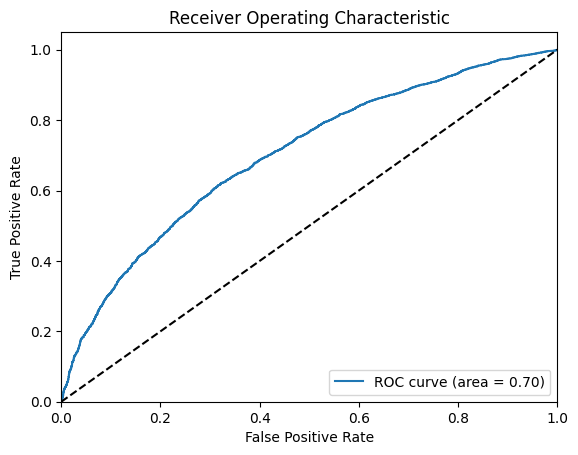

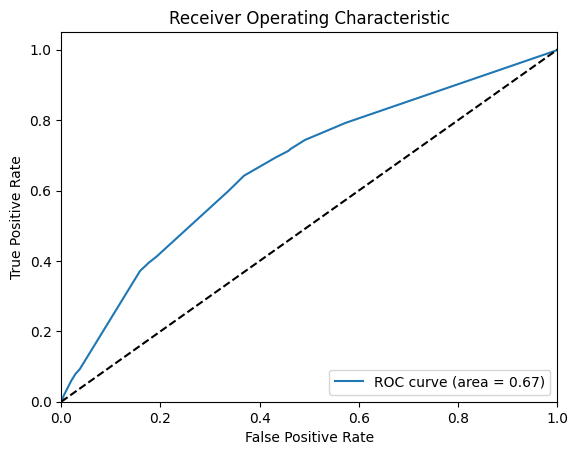

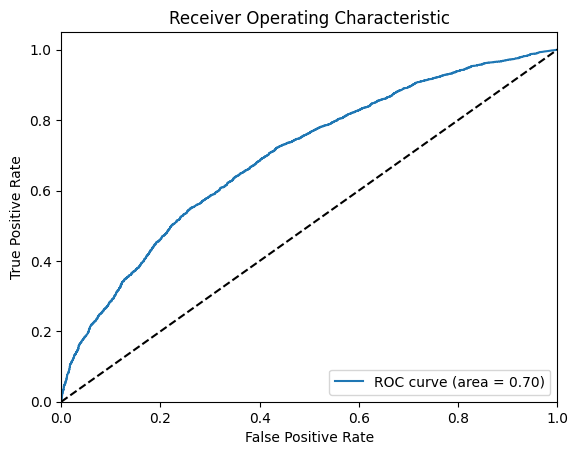

In [68]:
def plot_roc_curve(predictions, label_col):
    # Convert predictions to Pandas DataFrame
    predictions_df = predictions.select(['probability', label_col]).toPandas()

    # Extract probabilities and labels
    probabilities = predictions_df['probability'].apply(lambda x: x[1])
    labels = predictions_df[label_col]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for Logistic Regression model
plot_roc_curve(lr_predictions, "shares_binary")
plot_roc_curve(dt_predictions, "shares_binary")
plot_roc_curve(rf_predictions, "shares_binary")
